### Deep Learning
#### Assignment 4
Previously in 2_fullyconnected.ipynb and 3_regularization.ipynb, we trained fully connected networks to classify notMNIST characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from IPython.display import display, Image
from tensorflow.contrib.layers import flatten

/jet/var/python/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:

 - convolutions need the image data formatted as a cube (width by height by #channels)
 - labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
# np.argmax(array, axis=0/1) return the indices of the maximum values along an axis.
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## /-/-/-/-/-/-/ - --  - - - -

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    # Flattern the convolution output
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) 
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [9]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.307691
Minibatch accuracy: 0.0%
Validation accuracy: 9.7%
Minibatch loss at step 50: 1.638491
Minibatch accuracy: 43.8%
Validation accuracy: 61.5%
Minibatch loss at step 100: 0.645101
Minibatch accuracy: 81.2%
Validation accuracy: 71.7%
Minibatch loss at step 150: 1.005029
Minibatch accuracy: 68.8%
Validation accuracy: 76.7%
Minibatch loss at step 200: 0.549976
Minibatch accuracy: 87.5%
Validation accuracy: 77.5%
Minibatch loss at step 250: 1.245437
Minibatch accuracy: 56.2%
Validation accuracy: 76.8%
Minibatch loss at step 300: 0.788736
Minibatch accuracy: 81.2%
Validation accuracy: 79.8%
Minibatch loss at step 350: 0.486146
Minibatch accuracy: 87.5%
Validation accuracy: 79.3%
Minibatch loss at step 400: 0.677918
Minibatch accuracy: 81.2%
Validation accuracy: 79.0%
Minibatch loss at step 450: 0.411564
Minibatch accuracy: 87.5%
Validation accuracy: 80.5%
Minibatch loss at step 500: 0.610955
Minibatch accuracy: 93.8%
Validation accuracy: 81.4%
Min

### Problem 1
The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (nn.max_pool()) of stride 2 and kernel size 2.

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)) # there are [depth] number of weight set
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') #[1, 1, 1, 1] - strides, layer1_weights - filter
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    # Flattern the convolution output
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]]) 
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [7]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.958964
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.938787
Minibatch accuracy: 25.0%
Validation accuracy: 46.9%
Minibatch loss at step 100: 0.913327
Minibatch accuracy: 62.5%
Validation accuracy: 56.2%
Minibatch loss at step 150: 1.032664
Minibatch accuracy: 75.0%
Validation accuracy: 69.0%
Minibatch loss at step 200: 0.657779
Minibatch accuracy: 87.5%
Validation accuracy: 76.0%
Minibatch loss at step 250: 1.099389
Minibatch accuracy: 68.8%
Validation accuracy: 74.8%
Minibatch loss at step 300: 0.638528
Minibatch accuracy: 87.5%
Validation accuracy: 79.4%
Minibatch loss at step 350: 0.339121
Minibatch accuracy: 87.5%
Validation accuracy: 80.5%
Minibatch loss at step 400: 0.712578
Minibatch accuracy: 75.0%
Validation accuracy: 80.0%
Minibatch loss at step 450: 0.279338
Minibatch accuracy: 93.8%
Validation accuracy: 80.1%
Minibatch loss at step 500: 0.752314
Minibatch accuracy: 75.0%
Validation accuracy: 82.2%
M

### Problem 2
Try to get the best performance you can using a convolutional net. Look for example at the classic LeNet5 architecture, adding Dropout, and/or adding learning rate decay.

By modern standards, LeNet-5 is a very simple network. It only has 7 layers, among which there are 3 convolutional layers (C1, C3 and C5), 2 sub-sampling (pooling) layers (S2 and S4), and 1 fully connected layer (F6), that are followed by the output layer. Convolutional layers use 5 by 5 convolutions with stride 1. Sub-sampling layers are 2 by 2 average pooling layers. Tanh sigmoid activations are used throughout the network. There are several interesting architectural choices that were made in LeNet-5 that are not very common in the modern era of deep learning.

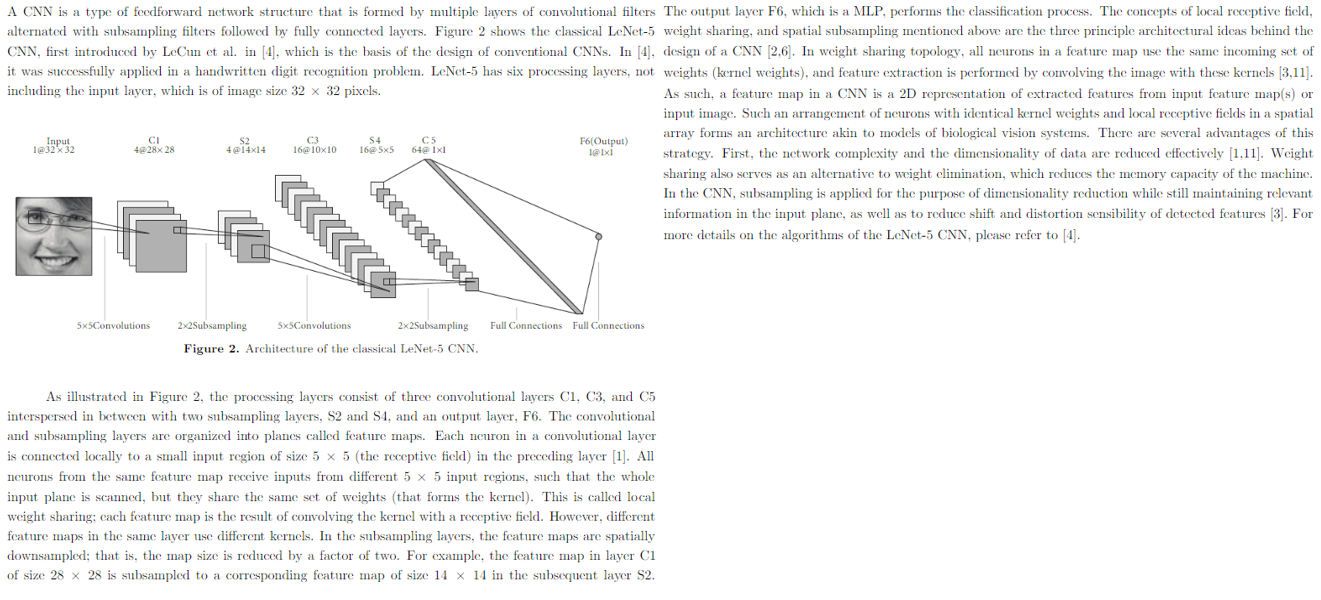

In [47]:
# https://www.researchgate.net/publication/299593011_Gender_Classification_A_Convolutional_Neural_Network_Approach
Image('5.PNG')

In [13]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden1 = 64
num_hidden2 = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)) # there are [depth] number of weight set
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden1, num_hidden2], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # Layer 1
        #conv1  
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') #[1, 1, 1, 1] - strides, layer1_weights - filter
        #ReLu1
    hidden = tf.nn.relu(conv + layer1_biases)
        #pool1
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    # Layer 2
        #conv2
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        #ReLu2
    hidden = tf.nn.relu(conv + layer2_biases)
        #pool2
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    # Flattern the convolution output
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 3 (FC)
        # FC3
    fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    # Layer 4 (FC) 
        # FC4 
    fc2 = tf.matmul(fc1, layer4_weights) + layer4_biases    

    # Layer 5 (FC) 
        # FC5 (logits in return) 
    return tf.matmul(fc2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  start_learning_rate = 0.05
  learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [14]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.492533
Minibatch accuracy: 18.8%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.082253
Minibatch accuracy: 12.5%
Validation accuracy: 29.6%
Minibatch loss at step 100: 0.691757
Minibatch accuracy: 81.2%
Validation accuracy: 61.8%
Minibatch loss at step 150: 1.272046
Minibatch accuracy: 62.5%
Validation accuracy: 67.5%
Minibatch loss at step 200: 0.826247
Minibatch accuracy: 68.8%
Validation accuracy: 75.3%
Minibatch loss at step 250: 1.233352
Minibatch accuracy: 62.5%
Validation accuracy: 73.4%
Minibatch loss at step 300: 0.589473
Minibatch accuracy: 87.5%
Validation accuracy: 79.8%
Minibatch loss at step 350: 0.631832
Minibatch accuracy: 81.2%
Validation accuracy: 77.9%
Minibatch loss at step 400: 0.932854
Minibatch accuracy: 75.0%
Validation accuracy: 80.8%
Minibatch loss at step 450: 0.255169
Minibatch accuracy: 93.8%
Validation accuracy: 80.6%
Minibatch loss at step 500: 0.806119
Minibatch accuracy: 81.2%
Validation accuracy: 82.2%
M

In [5]:
weights = {
    'wc1': tf.get_variable('W0', shape=(5,5,1,6), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2': tf.get_variable('W1', shape=(5,5,6,16), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(1,1,16,120), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(120*84,84), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(84,num_labels), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(120), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(84), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

In [11]:
  def conv_net(x, weights, biases):
    # Set 1 (C-ReLu-S)
        #conv1  
    conv = tf.nn.conv2d(x, weights['wc1'], [1, 1, 1, 1], padding='SAME') #[1, 1, 1, 1] - strides, layer1_weights - filter
        #ReLu1
    hidden = tf.nn.relu(conv + biases['bc1'])
        #pool1
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    # Set 2 (C-ReLu-S)
        #conv2
    conv = tf.nn.conv2d(pool, weights['wc2'], [1, 1, 1, 1], padding='VALID')
        #ReLu2
    hidden = tf.nn.relu(conv + biases['bc1'])
        #pool2
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
        # Set 3 (C-ReLu)
    conv = tf.nn.conv2d(pool, weights['wc3'], [1, 1, 1, 1], padding='VALID')
    hidden = tf.nn.relu(conv + biases['bc3'])
    
    # Flattern the convolution output
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 4 (FC)
        # FC4
    fc1 = tf.nn.relu(tf.matmul(reshape, weights['wc4']) + biases['bc4'])
    
    return tf.matmul(fc1, weights['wc5']) + biases['bc5']

In [7]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [16]:
batch_size = 128
patch_size = 5
depth = 16
num_hidden1 = 64
num_hidden2 = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  weights = {
    'wc1': tf.get_variable('W0', shape=(5,5,1,6), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2': tf.get_variable('W1', shape=(5,5,6,16), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(1,1,16,120), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(120*84,84), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(84,num_labels), initializer=tf.contrib.layers.xavier_initializer())}
  biases = {
    'bc1': tf.get_variable('B0', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(120), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(84), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer())}
  
  def conv_net(x, weights, biases):
    # Set 1 (C-ReLu-S)
        #conv1  
    conv = tf.nn.conv2d(x, weights['wc1'], [1, 1, 1, 1], padding='VALID') #[1, 1, 1, 1] - strides, layer1_weights - filter
        #ReLu1
    hidden = tf.nn.relu(conv + biases['bc1'])
        #pool1
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
    # Set 2 (C-ReLu-S)
        #conv2
    conv = tf.nn.conv2d(pool, weights['wc2'], [1, 1, 1, 1], padding='VALID')
        #ReLu2
    hidden = tf.nn.relu(conv + biases['bc1'])
        #pool2
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    
        # Set 3 (C-ReLu)
    conv = tf.nn.conv2d(pool, weights['wc3'], [1, 1, 1, 1], padding='VALID')
    hidden = tf.nn.relu(conv + biases['bc3'])
    
    # Flattern the convolution output
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 4 (FC)
        # FC4
    fc1 = tf.nn.relu(tf.matmul(reshape, weights['wc4']) + biases['bc4'])
    
    return tf.matmul(fc1, weights['wc5']) + biases['bc5']


  # Variables.
  logits = conv_net(tf_train_dataset, weights, biases)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  #start_learning_rate = 0.05
  #learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

ValueError: Dimensions must be equal, but are 16 and 6 for 'add_1' (op: 'Add') with input shapes: [128,8,8,16], [6].

In [24]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.303828
Minibatch accuracy: 10.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.304145
Minibatch accuracy: 9.4%
Validation accuracy: 10.0%
Minibatch loss at step 100: 2.303250
Minibatch accuracy: 7.0%
Validation accuracy: 10.0%
Minibatch loss at step 150: 2.304336
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 200: 2.302296
Minibatch accuracy: 10.9%
Validation accuracy: 10.0%
Minibatch loss at step 250: 2.301311
Minibatch accuracy: 13.3%
Validation accuracy: 12.0%
Minibatch loss at step 300: 2.301262
Minibatch accuracy: 15.6%
Validation accuracy: 10.0%
Minibatch loss at step 350: 2.301549
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 400: 2.303027
Minibatch accuracy: 7.8%
Validation accuracy: 10.0%
Minibatch loss at step 450: 2.303185
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 500: 2.303296
Minibatch accuracy: 9.4%
Validation accuracy: 10.0%
Miniba

## LeNet5 (variation) CNN is built below

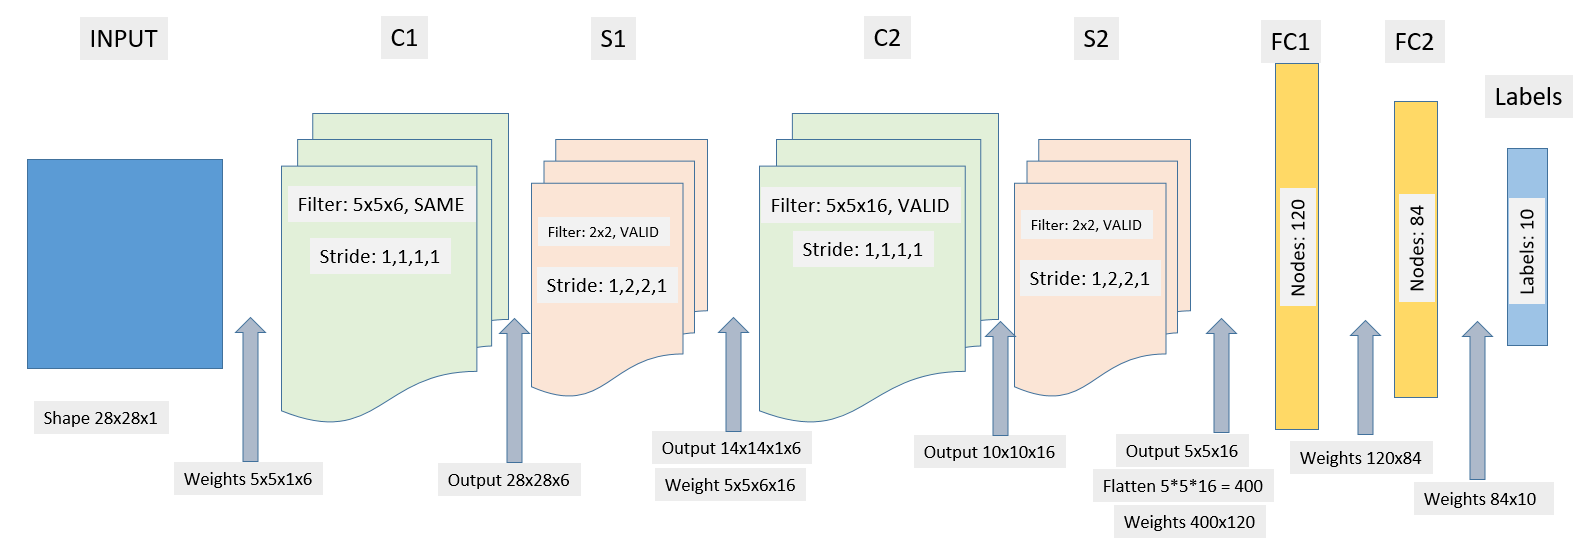

In [49]:
Image('6.PNG')

In [10]:
batch_size = 128
num_channels = 1
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)


  mu = 0
  sigma = 0.1
  conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
  conv1_b = tf.Variable(tf.zeros(6))
  conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
  conv2_b = tf.Variable(tf.zeros(16))
  fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
  fc1_b = tf.Variable(tf.zeros(120))
  fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
  fc2_b = tf.Variable(tf.zeros(84))
  fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
  fc3_b = tf.Variable(tf.zeros(10))


  def LeNet(x):    
    # Hyperparameters

    layer_depth = {
        'layer_1' : 6,
        'layer_2' : 16,
        'layer_3' : 120,
        'layer_f1' : 84
    }

    
    # TODO: Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x6.

    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b 
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.

    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.

    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.

    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.

    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

  # Variables.
  logits = LeNet(tf_train_dataset)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  #start_learning_rate = 0.05
  #learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(LeNet(tf_valid_dataset))
  test_prediction = tf.nn.softmax(LeNet(tf_test_dataset))

In [11]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.309824
Minibatch accuracy: 10.9%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.928065
Minibatch accuracy: 46.9%
Validation accuracy: 48.6%
Minibatch loss at step 100: 1.201391
Minibatch accuracy: 64.1%
Validation accuracy: 76.5%
Minibatch loss at step 150: 0.824042
Minibatch accuracy: 78.1%
Validation accuracy: 78.9%
Minibatch loss at step 200: 0.806106
Minibatch accuracy: 78.9%
Validation accuracy: 80.2%
Minibatch loss at step 250: 0.512347
Minibatch accuracy: 83.6%
Validation accuracy: 82.2%
Minibatch loss at step 300: 0.508084
Minibatch accuracy: 86.7%
Validation accuracy: 82.5%
Minibatch loss at step 350: 0.434561
Minibatch accuracy: 88.3%
Validation accuracy: 82.8%
Minibatch loss at step 400: 0.472014
Minibatch accuracy: 85.2%
Validation accuracy: 83.5%
Minibatch loss at step 450: 0.590302
Minibatch accuracy: 82.0%
Validation accuracy: 83.8%
Minibatch loss at step 500: 0.569758
Minibatch accuracy: 84.4%
Validation accuracy: 84.0%
M

### Train CNN with 2 epochs

In [46]:
num_steps = 2

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for epoch in range(num_steps):
    print('----------  epoch',epoch,'-------------')
    for step in range(len(train_labels)//batch_size+int(len(train_labels)%batch_size!=0)):   
        offset = (step * batch_size)
        batch_data = train_dataset[offset:min((offset + batch_size),len(train_dataset)), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
----------  epoch 0 -------------
Minibatch loss at step 0: 2.299272
Minibatch accuracy: 11.7%
Minibatch loss at step 50: 1.568478
Minibatch accuracy: 47.7%
Minibatch loss at step 100: 1.177637
Minibatch accuracy: 67.2%
Minibatch loss at step 150: 0.909933
Minibatch accuracy: 76.6%
Minibatch loss at step 200: 0.843510
Minibatch accuracy: 77.3%
Minibatch loss at step 250: 0.533028
Minibatch accuracy: 85.2%
Minibatch loss at step 300: 0.565072
Minibatch accuracy: 83.6%
Minibatch loss at step 350: 0.439315
Minibatch accuracy: 89.1%
Minibatch loss at step 400: 0.481346
Minibatch accuracy: 84.4%
Minibatch loss at step 450: 0.568036
Minibatch accuracy: 83.6%
Minibatch loss at step 500: 0.519466
Minibatch accuracy: 86.7%
Minibatch loss at step 550: 0.405076
Minibatch accuracy: 86.7%
Minibatch loss at step 600: 0.547502
Minibatch accuracy: 85.2%
Minibatch loss at step 650: 0.493884
Minibatch accuracy: 85.9%
Minibatch loss at step 700: 0.562140
Minibatch accuracy: 85.2%
Minibatch lo

#### Try to add dropout in fully connected layers anr/or learning rate decay

In [20]:
batch_size = 128
num_channels = 1
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #keep_prob = tf.placeholder(tf.float32)
    



  mu = 0
  sigma = 0.1
  conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
  conv1_b = tf.Variable(tf.zeros(6))
  conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
  conv2_b = tf.Variable(tf.zeros(16))
  fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
  fc1_b = tf.Variable(tf.zeros(120))
  fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
  fc2_b = tf.Variable(tf.zeros(84))
  fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
  fc3_b = tf.Variable(tf.zeros(10))


  def LeNet(x):    
    # Hyperparameters

    
    # TODO: Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x6.

    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b 
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.

    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.

    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    out1 = tf.nn.dropout(fc1, 0.85)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.

    fc2 = tf.matmul(out1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    out2 = tf.nn.dropout(fc2, 0.85)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.

    logits = tf.matmul(out2, fc3_w) + fc3_b
    return logits

  # Variables.
  logits = LeNet(tf_train_dataset)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  #start_learning_rate = 0.05
  #learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(LeNet(tf_valid_dataset))
  test_prediction = tf.nn.softmax(LeNet(tf_test_dataset))

In [21]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.305820
Minibatch accuracy: 10.9%
Validation accuracy: 13.2%
Minibatch loss at step 50: 1.885788
Minibatch accuracy: 37.5%
Validation accuracy: 44.1%
Minibatch loss at step 100: 1.357431
Minibatch accuracy: 59.4%
Validation accuracy: 67.7%
Minibatch loss at step 150: 1.038505
Minibatch accuracy: 74.2%
Validation accuracy: 74.4%
Minibatch loss at step 200: 0.864754
Minibatch accuracy: 73.4%
Validation accuracy: 76.3%
Minibatch loss at step 250: 0.617236
Minibatch accuracy: 83.6%
Validation accuracy: 78.1%
Minibatch loss at step 300: 0.611753
Minibatch accuracy: 83.6%
Validation accuracy: 79.2%
Minibatch loss at step 350: 0.563423
Minibatch accuracy: 80.5%
Validation accuracy: 80.0%
Minibatch loss at step 400: 0.598954
Minibatch accuracy: 82.0%
Validation accuracy: 80.4%
Minibatch loss at step 450: 0.724862
Minibatch accuracy: 81.2%
Validation accuracy: 81.2%
Minibatch loss at step 500: 0.676858
Minibatch accuracy: 82.0%
Validation accuracy: 81.5%
M

### Try batch normalization (BN) after the first convolution layer with ReLu
materials about BN: 
 - https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
 - https://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
 - https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
 
 We need to: 
 - 1) add a   tf.Variable(tf.ones([b])) / tf.Variable(tf.zeros([b]))  for learning scale(gamma) and shift(beta) params
 - 2) calculate batch_mean1, batch_var1 = tf.nn.moments(conv1,[0])
 - 3) add BN layer tf.nn.batch_normalization(conv1,batch_mean1,batch_var1,beta1,scale1,variance_epsilon=0.001)
 
 #### By adding only one layer BN (after first ConvLayer), Test accuracy increased on 2%

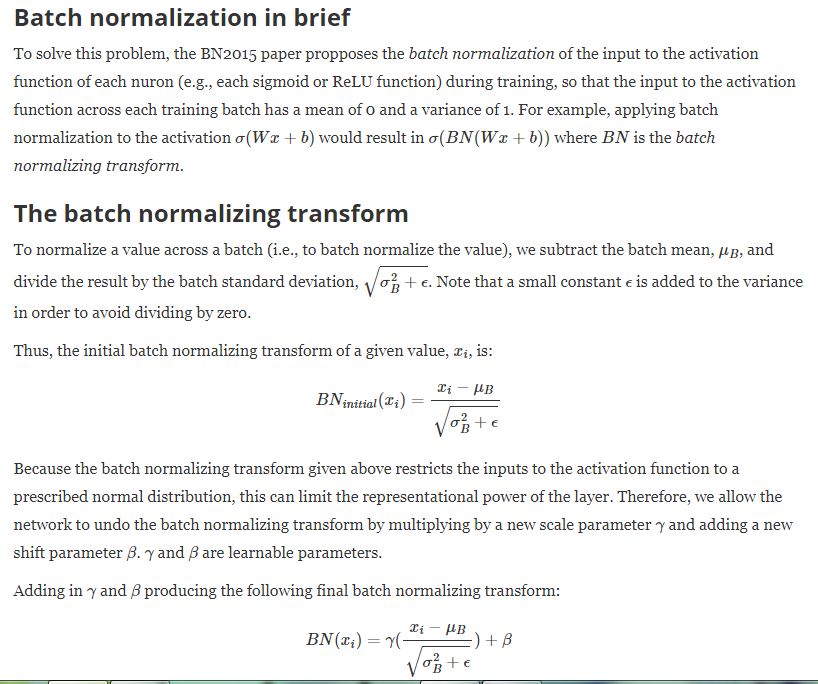

In [41]:
Image('9.PNG')

In [22]:
batch_size = 128
num_channels = 1
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #keep_prob = tf.placeholder(tf.float32)

  mu = 0
  sigma = 0.1
  conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
  conv1_b = tf.Variable(tf.zeros(6))
  conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
  conv2_b = tf.Variable(tf.zeros(16))
  fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
  fc1_b = tf.Variable(tf.zeros(120))
  fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
  fc2_b = tf.Variable(tf.zeros(84))
  fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
  fc3_b = tf.Variable(tf.zeros(10))
  
  # Learning parameters for Batch Normalization. The dimension is equal to (b)
  scale1 = tf.Variable(tf.ones([6]))
  beta1 = tf.Variable(tf.zeros([6]))

  def LeNet(x):    
    # Hyperparameters
    # Set this to True for training and False for testing
    
    
    # TODO: Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x6.

    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b 
    #Batch_Normalization
    batch_mean1, batch_var1 = tf.nn.moments(conv1,[0])
    norm1 = tf.nn.batch_normalization(conv1,batch_mean1,batch_var1,beta1,scale1,variance_epsilon=0.001)
    # TODO: Activation.
    conv1 = tf.nn.relu(norm1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.

    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.

    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.

    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.

    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

  # Variables.
  logits = LeNet(tf_train_dataset)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.


  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  #global_step = tf.Variable(0)  # count the number of steps taken.
  #start_learning_rate = 0.05
  #learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(LeNet(tf_valid_dataset))
  test_prediction = tf.nn.softmax(LeNet(tf_test_dataset))

In [23]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.520990
Minibatch accuracy: 8.6%
Validation accuracy: 13.2%
Minibatch loss at step 50: 1.232831
Minibatch accuracy: 59.4%
Validation accuracy: 69.1%
Minibatch loss at step 100: 0.949999
Minibatch accuracy: 74.2%
Validation accuracy: 79.9%
Minibatch loss at step 150: 0.774634
Minibatch accuracy: 81.2%
Validation accuracy: 81.0%
Minibatch loss at step 200: 0.718480
Minibatch accuracy: 78.9%
Validation accuracy: 81.5%
Minibatch loss at step 250: 0.551586
Minibatch accuracy: 84.4%
Validation accuracy: 83.1%
Minibatch loss at step 300: 0.426434
Minibatch accuracy: 90.6%
Validation accuracy: 83.9%
Minibatch loss at step 350: 0.431052
Minibatch accuracy: 88.3%
Validation accuracy: 84.0%
Minibatch loss at step 400: 0.444636
Minibatch accuracy: 87.5%
Validation accuracy: 84.5%
Minibatch loss at step 450: 0.591712
Minibatch accuracy: 83.6%
Validation accuracy: 85.0%
Minibatch loss at step 500: 0.503872
Minibatch accuracy: 83.6%
Validation accuracy: 85.7%
Mi

### Use 3 BN Layers before relu

In [14]:
batch_size = 128
num_channels = 1
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #keep_prob = tf.placeholder(tf.float32)
    
  mu = 0
  sigma = 0.1
  conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
  conv1_b = tf.Variable(tf.zeros(6))
  conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
  conv2_b = tf.Variable(tf.zeros(16))
  fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
  fc1_b = tf.Variable(tf.zeros(120))
  fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
  fc2_b = tf.Variable(tf.zeros(84))
  fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
  fc3_b = tf.Variable(tf.zeros(10))
  
  # Learning parameters for Batch Normalization. The dimension is equal to (b)
  scale1 = tf.Variable(tf.ones([6]))
  beta1 = tf.Variable(tf.zeros([6]))
    
  scale2 = tf.Variable(tf.ones([16]))
  beta2 = tf.Variable(tf.zeros([16]))

  scale3 = tf.Variable(tf.ones([120]))
  beta3 = tf.Variable(tf.zeros([120]))
    

  def LeNet(x):    
    # Hyperparameters
    # Set this to True for training and False for testing
    
    
    # TODO: Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x6.

    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b 
    # TODO: Activation.
    #Batch_Normalization
    batch_mean1, batch_var1 = tf.nn.moments(conv1,[0,1,2])
    norm1 = tf.nn.batch_normalization(conv1,batch_mean1,batch_var1,beta1,scale1,variance_epsilon=0.001)
    conv1 = tf.nn.relu(norm1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.

    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    #Batch_Normalization
    batch_mean2, batch_var2 = tf.nn.moments(conv2,[0,1,2])
    norm2 = tf.nn.batch_normalization(conv2,batch_mean2,batch_var2,beta2,scale2,variance_epsilon=0.001)
    # TODO: Activation.
    conv2 = tf.nn.relu(norm2)
    

    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.

    fc1 = tf.matmul(fc1,fc1_w) + fc1_b 
    #Batch_Normalization
    batch_mean3, batch_var3 = tf.nn.moments(fc1,[0])
    norm3 = tf.nn.batch_normalization(fc1,batch_mean3,batch_var3,beta3,scale3,variance_epsilon=0.001)
    # TODO: Activation.
    fc1 = tf.nn.relu(norm3)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.

    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

  # Variables.
  logits = LeNet(tf_train_dataset)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.


  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  start_learning_rate = 0.05
  learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(LeNet(tf_valid_dataset))
  test_prediction = tf.nn.softmax(LeNet(tf_test_dataset))

In [15]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.540943
Minibatch accuracy: 9.4%
Validation accuracy: 8.3%
Minibatch loss at step 50: 1.364836
Minibatch accuracy: 69.5%
Validation accuracy: 68.8%
Minibatch loss at step 100: 0.982455
Minibatch accuracy: 74.2%
Validation accuracy: 78.4%
Minibatch loss at step 150: 0.866117
Minibatch accuracy: 74.2%
Validation accuracy: 80.7%
Minibatch loss at step 200: 0.704747
Minibatch accuracy: 80.5%
Validation accuracy: 82.0%
Minibatch loss at step 250: 0.483477
Minibatch accuracy: 85.2%
Validation accuracy: 82.8%
Minibatch loss at step 300: 0.456689
Minibatch accuracy: 88.3%
Validation accuracy: 83.5%
Minibatch loss at step 350: 0.431777
Minibatch accuracy: 89.1%
Validation accuracy: 83.7%
Minibatch loss at step 400: 0.445319
Minibatch accuracy: 85.9%
Validation accuracy: 84.4%
Minibatch loss at step 450: 0.616280
Minibatch accuracy: 78.9%
Validation accuracy: 84.5%
Minibatch loss at step 500: 0.476560
Minibatch accuracy: 86.7%
Validation accuracy: 85.1%
Min

## Fixing the model for test time (is_training option)
Tensorflow function is used
                     
                     x_norm = tf.layers.batch_normalization(conv1, training=is_train)

In [60]:
batch_size = 128
num_channels = 1
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #keep_prob = tf.placeholder(tf.float32)


  mu = 0
  sigma = 0.1
  conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
  conv1_b = tf.Variable(tf.zeros(6))
  conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
  conv2_b = tf.Variable(tf.zeros(16))
  fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
  fc1_b = tf.Variable(tf.zeros(120))
  fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
  fc2_b = tf.Variable(tf.zeros(84))
  fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
  fc3_b = tf.Variable(tf.zeros(10))
       

  def LeNet(x, is_train):    
    # Hyperparameters
    # Set this to True for training and False for testing
    
    
    # TODO: Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b 
    #Batch_Normalization
    x_norm = tf.layers.batch_normalization(conv1, training=is_train)
    # TODO: Activation.
    conv1 = tf.nn.relu(x_norm)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b

    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b 

    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b

    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.

    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

  # Variables.
  logits = LeNet(tf_train_dataset, is_train=True)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.


  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  start_learning_rate = 0.05
  learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  with tf.control_dependencies(update_ops):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(LeNet(tf_valid_dataset, is_train=False))
  test_prediction = tf.nn.softmax(LeNet(tf_test_dataset, is_train=False))

In [61]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.495695
Minibatch accuracy: 7.8%
Validation accuracy: 9.3%
Minibatch loss at step 50: 0.985644
Minibatch accuracy: 72.7%
Validation accuracy: 71.9%
Minibatch loss at step 100: 0.895730
Minibatch accuracy: 77.3%
Validation accuracy: 77.1%
Minibatch loss at step 150: 0.802622
Minibatch accuracy: 77.3%
Validation accuracy: 76.9%
Minibatch loss at step 200: 0.748958
Minibatch accuracy: 78.1%
Validation accuracy: 79.0%
Minibatch loss at step 250: 0.439174
Minibatch accuracy: 85.9%
Validation accuracy: 81.0%
Minibatch loss at step 300: 0.495652
Minibatch accuracy: 85.2%
Validation accuracy: 83.3%
Minibatch loss at step 350: 0.384921
Minibatch accuracy: 91.4%
Validation accuracy: 83.1%
Minibatch loss at step 400: 0.437172
Minibatch accuracy: 85.2%
Validation accuracy: 82.0%
Minibatch loss at step 450: 0.538804
Minibatch accuracy: 82.8%
Validation accuracy: 84.1%
Minibatch loss at step 500: 0.458375
Minibatch accuracy: 84.4%
Validation accuracy: 84.4%
Min

## Fixing the model for test time manually (batch_norm_wrapper function)

In [64]:
batch_size = 128
num_channels = 1
num_labels = 10

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #keep_prob = tf.placeholder(tf.float32)


  mu = 0
  sigma = 0.1
  conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
  conv1_b = tf.Variable(tf.zeros(6))
  conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
  conv2_b = tf.Variable(tf.zeros(16))
  fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
  fc1_b = tf.Variable(tf.zeros(120))
  fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
  fc2_b = tf.Variable(tf.zeros(84))
  fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
  fc3_b = tf.Variable(tf.zeros(10))
    
  # Normalization variables

       
  def batch_norm_wrapper(inputs, is_training, decay = 0.999):

    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)
    
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2]) # find min and var for EACH DEPTH, so the dimension = depth
                                                              # or = input[-1], so the dimensions btw bath_mean-pop_mean-scale-equal
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, variance_epsilon=0.001)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, variance_epsilon=0.001)
    
  def LeNet(x, is_train):    
    # Hyperparameters
    # Set this to True for training and False for testing
    
    
    # TODO: Layer 1: Convolutional. Input = 28x28x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b
    #Batch_Normalization
    x_norm = batch_norm_wrapper(conv1, is_training=is_train)
    # TODO: Activation.
    conv1 = tf.nn.relu(x_norm)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    #Batch_Normalization
    conv2 = batch_norm_wrapper(conv2, is_training=is_train)
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b 
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.

    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

  # Variables.
  logits = LeNet(tf_train_dataset, is_train=True)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.


  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# Decaying learning rate
  global_step = tf.Variable(0)  # count the number of steps taken.
  start_learning_rate = 0.05
  learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 1000, 0.85, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(LeNet(tf_valid_dataset, is_train=False))
  test_prediction = tf.nn.softmax(LeNet(tf_test_dataset, is_train=False))

In [65]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.446910
Minibatch accuracy: 10.9%
Validation accuracy: 19.5%
Minibatch loss at step 50: 0.973795
Minibatch accuracy: 73.4%
Validation accuracy: 60.8%
Minibatch loss at step 100: 0.880778
Minibatch accuracy: 74.2%
Validation accuracy: 72.8%
Minibatch loss at step 150: 0.748850
Minibatch accuracy: 80.5%
Validation accuracy: 74.3%
Minibatch loss at step 200: 0.597402
Minibatch accuracy: 83.6%
Validation accuracy: 77.7%
Minibatch loss at step 250: 0.439369
Minibatch accuracy: 84.4%
Validation accuracy: 77.5%
Minibatch loss at step 300: 0.488679
Minibatch accuracy: 87.5%
Validation accuracy: 77.2%
Minibatch loss at step 350: 0.400155
Minibatch accuracy: 91.4%
Validation accuracy: 81.3%
Minibatch loss at step 400: 0.425159
Minibatch accuracy: 86.7%
Validation accuracy: 79.2%
Minibatch loss at step 450: 0.581310
Minibatch accuracy: 82.8%
Validation accuracy: 80.2%
Minibatch loss at step 500: 0.478849
Minibatch accuracy: 87.5%
Validation accuracy: 78.1%
M